In [17]:
%pip install synthcity[all]
%pip install catenets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 63.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.6/127.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 7.0 MB/s eta 0:00:00
     ━━━

In [1]:
from synthcity.plugins import Plugins
from synthcity.metrics.eval_statistical import AlphaPrecision, InverseKLDivergence, MaximumMeanDiscrepancy, WassersteinDistance
from synthcity.plugins.core.dataloader import GenericDataLoader
from synthcity.utils.serialization import save_to_file, load_from_file
import matplotlib.pyplot as plt
import pandas as pd
from catenets.models.jax import *
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup
import numpy as np
from sklearn.metrics import mean_squared_error
from os import listdir
from sklearn.preprocessing import OneHotEncoder


[KeOps] Warning : There were warnings or errors :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:16:10: fatal error: cuda.h: No such file or directory
 #include <cuda.h>
          ^~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warn

In [2]:
def train_models(gen_list, datasets, n_runs):
    for g in gen_list:
        for dataset in datasets:
            for i in range(n_runs):
                print(f'Training model {g} iteration {i} on dataset {dataset}')
                model = Plugins().get(g)
                model.fit(datasets[dataset])
                fp = 'models/' + g + '_' + dataset + '_' + str(i) + '.pkl'
                print(f'Saving model {g} iteration {i} on dataset {dataset}')
                save_to_file(fp, model)

In [3]:
def generate_data(models, n):
    for fp in models:
        g = load_from_file('models/' + fp)
        df = g.generate(count = n).dataframe()

        name_list = fp.split('.')
        name = name_list[0]
        df.to_csv('syn_data/' + name + '.csv', index=False)

In [4]:
def get_CATE_PEHE(datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = pd.DataFrame(columns=['generator', 'learner', 'rmse'])
    for d in datasets:
        dataset = datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])  
        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            pred = learner.predict(X_t)
            cate = mu1 - mu0
            rmse = mean_squared_error(cate, pred, squared = False)
            results.loc[len(results.index)] = [d, learner.__str__(), rmse]
            print(f'{learner} complete on {d}')

    return results

In [5]:
def get_CATE_estimates(training_datasets, X_t, mu0, mu1, outcome_col, treatment_col, include_S = True):
    results = X_t.copy()
    results = pd.concat([results, mu0, mu1], axis=1)
    results['CATE'] = results['mu1'] - results['mu0']

    for d in training_datasets:
        dataset = training_datasets[d]
        X = np.array(dataset.drop([treatment_col, outcome_col], axis=1))
        y = np.array(dataset[outcome_col])
        w = np.array(dataset[treatment_col])

        if include_S:
            learners = [TNet(), SNet(), PWNet(), RANet(), DRNet()]
        else:
            learners = [TNet(), PWNet(), RANet(), DRNet()]

        for learner in learners:
            learner.fit(X,y,w)
            X_t_array = np.array(X_t)
            pred = learner.predict(X_t_array)
            col = d.split('.')[0] + '_' + learner.__str__()
            results[col] = pred
        
            print(f'{learner} complete on {d}')
            
    return results

In [6]:
def rate_of_flipping(d, cols):
    rates = pd.DataFrame()
    for c in cols:
        m = d['CATE'] * d[c]
        wrong = sum(m<0)
        rate = wrong / d.shape[0]
        rates[c] = [rate]
    rates = rates.transpose()
    return rates

In [7]:
def standard_metrics(datasets, real, metrics):
    results = pd.DataFrame(columns = ['dataset', 'metric', 'result'])
    for d in datasets:
        dataset = GenericDataLoader(datasets[d])
        for m in metrics:
            metric = metrics[m]
            result = metric.evaluate(real, dataset)
            for r in result:
                results.loc[len(results.index)] = [d, r, result[r]]
    
    return results

In [8]:
def encode_acic_datasets(real, syn_data):
    encoder = OneHotEncoder()
    categorical = ['x_2', 'x_21', 'x_24']
    encoded = encoder.fit_transform(real[categorical])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
    real_encoded = pd.concat([real, encoded_df], axis=1)
    real_encoded.drop(categorical, axis=1, inplace=True)

    syn_data_encoded = {}
    for d in syn_data:
        syn_dataset = syn_data[d]
        encoded = encoder.transform(syn_dataset[categorical])
        encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical))
        syn_encoded = pd.concat([syn_dataset, encoded_df], axis=1)
        syn_encoded.drop(categorical, axis=1, inplace=True)
        syn_data_encoded[d] = syn_encoded
    
    return real_encoded, syn_data_encoded

## Load real datasets

In [9]:
ihdp_full = pd.read_csv('../Datasets/ihdp.csv')
ihdp = ihdp_full.drop(['y_cfactual', 'mu0', 'mu1'], axis=1)

#train on 80% of the data, the remaining 20% for testing of CATE estimators
train_ihdp = ihdp.loc[[i for i in range(600)]]
test_ihdp = ihdp.loc[[i+600 for i in range(147)]]

In [10]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [20]:
twins = pd.read_csv('../Datasets/twins.csv')

In [11]:
acic_full = pd.read_csv('../Datasets/acic.csv')
acic_full['y'] = acic_full['y0']
acic_full.loc[acic_full['z']==1, 'y'] = acic_full.loc[acic_full['z']==1, 'y1']

acic = acic_full.drop(['y0', 'y1', 'mu0', 'mu1'], axis=1)
acic_train = acic.loc[[i for i in range(4000)]]
#acic_test = acic.loc[[i+4000 for i in range(802)]]

## Train generative models

In [256]:
gen_list = ['ctgan', 'arf', 'ddpm']
datasets = {}
datasets['jobs'] = jobs

In [257]:
train_models(gen_list, datasets, 1)

[2024-04-15T04:59:33.211033+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T04:59:33.211900+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T04:59:33.212316+0000][1026950][CRITICAL] module plugin_goggle load failed


Training model ctgan iteration 0 on dataset jobs


 32%|███▏      | 649/2000 [00:35<01:14, 18.11it/s]
[2024-04-15T05:00:09.695984+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:09.696523+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:09.696890+0000][1026950][CRITICAL] module plugin_goggle load failed


Saving model ctgan iteration 0 on dataset jobs
Training model arf iteration 0 on dataset jobs
Initial accuracy is 0.6648199445983379


[2024-04-15T05:00:11.707161+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:11.707643+0000][1026950][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_goggle' has no attribute 'plugin'
[2024-04-15T05:00:11.708002+0000][1026950][CRITICAL] module plugin_goggle load failed


Iteration number 1 reached accuracy of 0.3808864265927978.
Saving model arf iteration 0 on dataset jobs
Training model ddpm iteration 0 on dataset jobs


Epoch: 100%|██████████| 1000/1000 [00:13<00:00, 74.59it/s, loss=0.941]


Saving model ddpm iteration 0 on dataset jobs


## Generate synthetic datasets

In [258]:
jobs_models = [i for i in listdir('models') if 'jobs' in i]

In [261]:
generate_data(jobs_models, 722)

## Run CATE estimators

In [89]:
#IHDP
X_t = np.array(test_ihdp.drop(['treatment', 'y_factual'], axis=1))
mu0 = ihdp_full.loc[[i+600 for i in range(147)]]['mu0']
mu1 = ihdp_full.loc[[i+600 for i in range(147)]]['mu1']

In [118]:
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        
syn_data['real'] = ihdp

X_t = ihdp.drop(['treatment', 'y_factual'], axis=1)
mu0 = ihdp_full['mu0']
mu1 = ihdp_full['mu1']

In [119]:
ihdp_cate_estims = get_CATE_estimates(syn_data, X_t, mu0, mu1, 'y_factual', 'treatment')

TNet() complete on tvae_ihdp_0.csv
SNet() complete on tvae_ihdp_0.csv
PWNet() complete on tvae_ihdp_0.csv
RANet() complete on tvae_ihdp_0.csv
DRNet() complete on tvae_ihdp_0.csv
TNet() complete on ctgan_ihdp_4.csv
SNet() complete on ctgan_ihdp_4.csv
PWNet() complete on ctgan_ihdp_4.csv
RANet() complete on ctgan_ihdp_4.csv
DRNet() complete on ctgan_ihdp_4.csv
TNet() complete on ddpm_ihdp_1.csv
SNet() complete on ddpm_ihdp_1.csv
PWNet() complete on ddpm_ihdp_1.csv
RANet() complete on ddpm_ihdp_1.csv
DRNet() complete on ddpm_ihdp_1.csv
TNet() complete on ctgan_ihdp_0.csv
SNet() complete on ctgan_ihdp_0.csv
PWNet() complete on ctgan_ihdp_0.csv
RANet() complete on ctgan_ihdp_0.csv
DRNet() complete on ctgan_ihdp_0.csv
TNet() complete on arf_ihdp_3.csv
SNet() complete on arf_ihdp_3.csv
PWNet() complete on arf_ihdp_3.csv
RANet() complete on arf_ihdp_3.csv
DRNet() complete on arf_ihdp_3.csv
TNet() complete on ddpm_ihdp_2.csv
SNet() complete on ddpm_ihdp_2.csv
PWNet() complete on ddpm_ihdp_2.csv

In [28]:
ihdp_cate_estims.to_csv('all_ihdp_cate.csv', index=False)

NameError: name 'ihdp_cate_estims' is not defined

In [183]:
cols = ['tvae_ihdp_0TNet()',
 'tvae_ihdp_0SNet()',
 'tvae_ihdp_0PWNet()',
 'tvae_ihdp_0RANet()',
 'tvae_ihdp_0DRNet()',
 'ctgan_ihdp_4TNet()',
 'ctgan_ihdp_4SNet()',
 'ctgan_ihdp_4PWNet()',
 'ctgan_ihdp_4RANet()',
 'ctgan_ihdp_4DRNet()',
 'ddpm_ihdp_1TNet()',
 'ddpm_ihdp_1SNet()',
 'ddpm_ihdp_1PWNet()',
 'ddpm_ihdp_1RANet()',
 'ddpm_ihdp_1DRNet()',
 'ctgan_ihdp_0TNet()',
 'ctgan_ihdp_0SNet()',
 'ctgan_ihdp_0PWNet()',
 'ctgan_ihdp_0RANet()',
 'ctgan_ihdp_0DRNet()',
 'arf_ihdp_3TNet()',
 'arf_ihdp_3SNet()',
 'arf_ihdp_3PWNet()',
 'arf_ihdp_3RANet()',
 'arf_ihdp_3DRNet()',
 'ddpm_ihdp_2TNet()',
 'ddpm_ihdp_2SNet()',
 'ddpm_ihdp_2PWNet()',
 'ddpm_ihdp_2RANet()',
 'ddpm_ihdp_2DRNet()',
 'tvae_ihdp_4TNet()',
 'tvae_ihdp_4SNet()',
 'tvae_ihdp_4PWNet()',
 'tvae_ihdp_4RANet()',
 'tvae_ihdp_4DRNet()',
 'ddpm_ihdp_3TNet()',
 'ddpm_ihdp_3SNet()',
 'ddpm_ihdp_3PWNet()',
 'ddpm_ihdp_3RANet()',
 'ddpm_ihdp_3DRNet()',
 'tvae_ihdp_3TNet()',
 'tvae_ihdp_3SNet()',
 'tvae_ihdp_3PWNet()',
 'tvae_ihdp_3RANet()',
 'tvae_ihdp_3DRNet()',
 'nflow_ihdp_3TNet()',
 'nflow_ihdp_3SNet()',
 'nflow_ihdp_3PWNet()',
 'nflow_ihdp_3RANet()',
 'nflow_ihdp_3DRNet()',
 'ddpm_ihdp_0TNet()',
 'ddpm_ihdp_0SNet()',
 'ddpm_ihdp_0PWNet()',
 'ddpm_ihdp_0RANet()',
 'ddpm_ihdp_0DRNet()',
 'arf_ihdp_1TNet()',
 'arf_ihdp_1SNet()',
 'arf_ihdp_1PWNet()',
 'arf_ihdp_1RANet()',
 'arf_ihdp_1DRNet()',
 'arf_ihdp_4TNet()',
 'arf_ihdp_4SNet()',
 'arf_ihdp_4PWNet()',
 'arf_ihdp_4RANet()',
 'arf_ihdp_4DRNet()',
 'arf_ihdp_0TNet()',
 'arf_ihdp_0SNet()',
 'arf_ihdp_0PWNet()',
 'arf_ihdp_0RANet()',
 'arf_ihdp_0DRNet()',
 'tvae_ihdp_2TNet()',
 'tvae_ihdp_2SNet()',
 'tvae_ihdp_2PWNet()',
 'tvae_ihdp_2RANet()',
 'tvae_ihdp_2DRNet()',
 'nflow_ihdp_1TNet()',
 'nflow_ihdp_1SNet()',
 'nflow_ihdp_1PWNet()',
 'nflow_ihdp_1RANet()',
 'nflow_ihdp_1DRNet()',
 'arf_ihdp_2TNet()',
 'arf_ihdp_2SNet()',
 'arf_ihdp_2PWNet()',
 'arf_ihdp_2RANet()',
 'arf_ihdp_2DRNet()',
 'nflow_ihdp_4TNet()',
 'nflow_ihdp_4SNet()',
 'nflow_ihdp_4PWNet()',
 'nflow_ihdp_4RANet()',
 'nflow_ihdp_4DRNet()',
 'ctgan_ihdp_3TNet()',
 'ctgan_ihdp_3SNet()',
 'ctgan_ihdp_3PWNet()',
 'ctgan_ihdp_3RANet()',
 'ctgan_ihdp_3DRNet()',
 'nflow_ihdp_0TNet()',
 'nflow_ihdp_0SNet()',
 'nflow_ihdp_0PWNet()',
 'nflow_ihdp_0RANet()',
 'nflow_ihdp_0DRNet()',
 'ddpm_ihdp_4TNet()',
 'ddpm_ihdp_4SNet()',
 'ddpm_ihdp_4PWNet()',
 'ddpm_ihdp_4RANet()',
 'ddpm_ihdp_4DRNet()',
 'ctgan_ihdp_2TNet()',
 'ctgan_ihdp_2SNet()',
 'ctgan_ihdp_2PWNet()',
 'ctgan_ihdp_2RANet()',
 'ctgan_ihdp_2DRNet()',
 'tvae_ihdp_1TNet()',
 'tvae_ihdp_1SNet()',
 'tvae_ihdp_1PWNet()',
 'tvae_ihdp_1RANet()',
 'tvae_ihdp_1DRNet()',
 'nflow_ihdp_2TNet()',
 'nflow_ihdp_2SNet()',
 'nflow_ihdp_2PWNet()',
 'nflow_ihdp_2RANet()',
 'nflow_ihdp_2DRNet()',
 'ctgan_ihdp_1TNet()',
 'ctgan_ihdp_1SNet()',
 'ctgan_ihdp_1PWNet()',
 'ctgan_ihdp_1RANet()',
 'ctgan_ihdp_1DRNet()',
 'realTNet()',
 'realSNet()',
 'realPWNet()',
 'realRANet()',
 'realDRNet()']

In [184]:
rates = rate_of_flipping(ihdp_cate_estims, cols)

In [284]:
rates.to_csv('ihdp_rate_of_flipping.csv', index=False)

In [97]:
#ACIC
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)


acic_test_encoded = acic_encoded.loc[[i+4000 for i in range(802)]]

X_t = np.array(acic_test_encoded.drop(['z', 'y'], axis=1))
mu0 = acic_full.loc[[i+4000 for i in range(802)]]['mu0']
mu1 = acic_full.loc[[i+4000 for i in range(802)]]['mu1']

In [98]:
results = get_CATE_PEHE(syn_data_encoded, X_t, mu0, mu1, 'y', 'z', include_S = False)

TNet() complete on nflow_acic_0.csv
PWNet() complete on nflow_acic_0.csv
RANet() complete on nflow_acic_0.csv
DRNet() complete on nflow_acic_0.csv
TNet() complete on arf_acic_3.csv
PWNet() complete on arf_acic_3.csv
RANet() complete on arf_acic_3.csv
DRNet() complete on arf_acic_3.csv
TNet() complete on nflow_acic_4.csv
PWNet() complete on nflow_acic_4.csv
RANet() complete on nflow_acic_4.csv
DRNet() complete on nflow_acic_4.csv
TNet() complete on ctgan_acic_2.csv
PWNet() complete on ctgan_acic_2.csv
RANet() complete on ctgan_acic_2.csv
DRNet() complete on ctgan_acic_2.csv
TNet() complete on tvae_acic_0.csv
PWNet() complete on tvae_acic_0.csv
RANet() complete on tvae_acic_0.csv
DRNet() complete on tvae_acic_0.csv
TNet() complete on ddpm_acic_0.csv
PWNet() complete on ddpm_acic_0.csv
RANet() complete on ddpm_acic_0.csv
DRNet() complete on ddpm_acic_0.csv
TNet() complete on arf_acic_1.csv
PWNet() complete on arf_acic_1.csv
RANet() complete on arf_acic_1.csv
DRNet() complete on arf_acic_1

In [99]:
acic_train_encoded = acic_encoded.loc[[i for i in range(4000)]]

real_data = {'real':acic_train_encoded}
real_results = get_CATE_PEHE(real_data, X_t, mu0, mu1, 'y', 'z', include_S = True)

TNet() complete on real
PWNet() complete on real
RANet() complete on real
DRNet() complete on real


In [100]:
results['generator'] = [i.split('_')[0] + i.split('_')[2][0]  for i in results['generator']]

In [101]:
results['gen_type'] = [i[:-1] for i in results['generator']]

In [102]:
real_results['gen_type'] = real_results['generator']

In [103]:
all_results = pd.concat([results, real_results])

In [105]:
all_results.to_csv('acic_CATE_PEHE.csv', index=False)

In [35]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

syn_data_encoded['real'] = acic_encoded

X_t = acic_encoded.drop(['z', 'y'], axis=1)
mu0 = acic_full['mu0']
mu1 = acic_full['mu1']

In [36]:
acic_cate_estims = get_CATE_estimates(syn_data_encoded, X_t, mu0, mu1, 'y', 'z', include_S = False)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


TNet() complete on nflow_acic_0.csv
PWNet() complete on nflow_acic_0.csv
RANet() complete on nflow_acic_0.csv
DRNet() complete on nflow_acic_0.csv
TNet() complete on arf_acic_3.csv
PWNet() complete on arf_acic_3.csv
RANet() complete on arf_acic_3.csv
DRNet() complete on arf_acic_3.csv
TNet() complete on nflow_acic_4.csv
PWNet() complete on nflow_acic_4.csv
RANet() complete on nflow_acic_4.csv
DRNet() complete on nflow_acic_4.csv
TNet() complete on ctgan_acic_2.csv
PWNet() complete on ctgan_acic_2.csv
RANet() complete on ctgan_acic_2.csv
DRNet() complete on ctgan_acic_2.csv
TNet() complete on tvae_acic_0.csv
PWNet() complete on tvae_acic_0.csv
RANet() complete on tvae_acic_0.csv
DRNet() complete on tvae_acic_0.csv
TNet() complete on ddpm_acic_0.csv
PWNet() complete on ddpm_acic_0.csv
RANet() complete on ddpm_acic_0.csv
DRNet() complete on ddpm_acic_0.csv
TNet() complete on arf_acic_1.csv
PWNet() complete on arf_acic_1.csv
RANet() complete on arf_acic_1.csv
DRNet() complete on arf_acic_1

In [38]:
acic_cate_estims.to_csv('all_acic_cate.csv', index=False)

In [41]:
[i for i in acic_cate_estims.columns]

['x_1',
 'x_3',
 'x_4',
 'x_5',
 'x_6',
 'x_7',
 'x_8',
 'x_9',
 'x_10',
 'x_11',
 'x_12',
 'x_13',
 'x_14',
 'x_15',
 'x_16',
 'x_17',
 'x_18',
 'x_19',
 'x_20',
 'x_22',
 'x_23',
 'x_25',
 'x_26',
 'x_27',
 'x_28',
 'x_29',
 'x_30',
 'x_31',
 'x_32',
 'x_33',
 'x_34',
 'x_35',
 'x_36',
 'x_37',
 'x_38',
 'x_39',
 'x_40',
 'x_41',
 'x_42',
 'x_43',
 'x_44',
 'x_45',
 'x_46',
 'x_47',
 'x_48',
 'x_49',
 'x_50',
 'x_51',
 'x_52',
 'x_53',
 'x_54',
 'x_55',
 'x_56',
 'x_57',
 'x_58',
 'x_2_A',
 'x_2_B',
 'x_2_C',
 'x_2_D',
 'x_2_E',
 'x_2_F',
 'x_21_A',
 'x_21_B',
 'x_21_C',
 'x_21_D',
 'x_21_E',
 'x_21_F',
 'x_21_G',
 'x_21_H',
 'x_21_I',
 'x_21_J',
 'x_21_K',
 'x_21_L',
 'x_21_M',
 'x_21_N',
 'x_21_O',
 'x_21_P',
 'x_24_A',
 'x_24_B',
 'x_24_C',
 'x_24_D',
 'x_24_E',
 'mu0',
 'mu1',
 'CATE',
 'nflow_acic_0_TNet()',
 'nflow_acic_0_PWNet()',
 'nflow_acic_0_RANet()',
 'nflow_acic_0_DRNet()',
 'arf_acic_3_TNet()',
 'arf_acic_3_PWNet()',
 'arf_acic_3_RANet()',
 'arf_acic_3_DRNet()',
 'nflow

In [42]:
cols = ['nflow_acic_0_TNet()',
 'nflow_acic_0_PWNet()',
 'nflow_acic_0_RANet()',
 'nflow_acic_0_DRNet()',
 'arf_acic_3_TNet()',
 'arf_acic_3_PWNet()',
 'arf_acic_3_RANet()',
 'arf_acic_3_DRNet()',
 'nflow_acic_4_TNet()',
 'nflow_acic_4_PWNet()',
 'nflow_acic_4_RANet()',
 'nflow_acic_4_DRNet()',
 'ctgan_acic_2_TNet()',
 'ctgan_acic_2_PWNet()',
 'ctgan_acic_2_RANet()',
 'ctgan_acic_2_DRNet()',
 'tvae_acic_0_TNet()',
 'tvae_acic_0_PWNet()',
 'tvae_acic_0_RANet()',
 'tvae_acic_0_DRNet()',
 'ddpm_acic_0_TNet()',
 'ddpm_acic_0_PWNet()',
 'ddpm_acic_0_RANet()',
 'ddpm_acic_0_DRNet()',
 'arf_acic_1_TNet()',
 'arf_acic_1_PWNet()',
 'arf_acic_1_RANet()',
 'arf_acic_1_DRNet()',
 'arf_acic_2_TNet()',
 'arf_acic_2_PWNet()',
 'arf_acic_2_RANet()',
 'arf_acic_2_DRNet()',
 'nflow_acic_2_TNet()',
 'nflow_acic_2_PWNet()',
 'nflow_acic_2_RANet()',
 'nflow_acic_2_DRNet()',
 'tvae_acic_2_TNet()',
 'tvae_acic_2_PWNet()',
 'tvae_acic_2_RANet()',
 'tvae_acic_2_DRNet()',
 'ctgan_acic_4_TNet()',
 'ctgan_acic_4_PWNet()',
 'ctgan_acic_4_RANet()',
 'ctgan_acic_4_DRNet()',
 'ddpm_acic_2_TNet()',
 'ddpm_acic_2_PWNet()',
 'ddpm_acic_2_RANet()',
 'ddpm_acic_2_DRNet()',
 'ctgan_acic_1_TNet()',
 'ctgan_acic_1_PWNet()',
 'ctgan_acic_1_RANet()',
 'ctgan_acic_1_DRNet()',
 'arf_acic_0_TNet()',
 'arf_acic_0_PWNet()',
 'arf_acic_0_RANet()',
 'arf_acic_0_DRNet()',
 'arf_acic_4_TNet()',
 'arf_acic_4_PWNet()',
 'arf_acic_4_RANet()',
 'arf_acic_4_DRNet()',
 'ctgan_acic_3_TNet()',
 'ctgan_acic_3_PWNet()',
 'ctgan_acic_3_RANet()',
 'ctgan_acic_3_DRNet()',
 'tvae_acic_1_TNet()',
 'tvae_acic_1_PWNet()',
 'tvae_acic_1_RANet()',
 'tvae_acic_1_DRNet()',
 'ctgan_acic_0_TNet()',
 'ctgan_acic_0_PWNet()',
 'ctgan_acic_0_RANet()',
 'ctgan_acic_0_DRNet()',
 'ddpm_acic_1_TNet()',
 'ddpm_acic_1_PWNet()',
 'ddpm_acic_1_RANet()',
 'ddpm_acic_1_DRNet()',
 'ddpm_acic_3_TNet()',
 'ddpm_acic_3_PWNet()',
 'ddpm_acic_3_RANet()',
 'ddpm_acic_3_DRNet()',
 'tvae_acic_3_TNet()',
 'tvae_acic_3_PWNet()',
 'tvae_acic_3_RANet()',
 'tvae_acic_3_DRNet()',
 'tvae_acic_4_TNet()',
 'tvae_acic_4_PWNet()',
 'tvae_acic_4_RANet()',
 'tvae_acic_4_DRNet()',
 'ddpm_acic_4_TNet()',
 'ddpm_acic_4_PWNet()',
 'ddpm_acic_4_RANet()',
 'ddpm_acic_4_DRNet()',
 'nflow_acic_1_TNet()',
 'nflow_acic_1_PWNet()',
 'nflow_acic_1_RANet()',
 'nflow_acic_1_DRNet()',
 'nflow_acic_3_TNet()',
 'nflow_acic_3_PWNet()',
 'nflow_acic_3_RANet()',
 'nflow_acic_3_DRNet()',
 'real_TNet()',
 'real_PWNet()',
 'real_RANet()',
 'real_DRNet()']

In [43]:
rates = rate_of_flipping(acic_cate_estims, cols)

In [47]:
rates.to_csv('acic_rate_of_flipping.csv')

## Statistical metrics

In [218]:
inv_kl = InverseKLDivergence()
alpha_prec = AlphaPrecision()

In [274]:
#IHDP
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        syn_data[i].loc[:, 'treatment']= syn_data[i]['treatment'].replace(True, 1).replace(False, 0)

In [275]:
ihdp.loc[:, 'treatment']= ihdp['treatment'].replace(True, 1).replace(False, 0)

In [276]:
d = GenericDataLoader(ihdp.loc[:599])

In [17]:
metrics = {'inv kl': InverseKLDivergence(), 'alpha prec': AlphaPrecision()}

In [279]:
stat_results = standard_metrics(syn_data, d, metrics)

In [281]:
stat_results.to_csv('ihdp_standard_metrics.csv')

In [15]:
#ACIC
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

In [19]:
d = GenericDataLoader(acic_encoded.loc[:3999])

In [25]:
acic_standard_metrics = standard_metrics(syn_data_encoded, d, metrics)

In [27]:
acic_standard_metrics.to_csv('acic_standard_metrics.csv', index=False)

## Checking outcome divergence

In [270]:
def outcome_divergence(syn_data, real, treatment_column):
    results = pd.DataFrame(columns=['name', 'inv_kl'])
    inv_kl = InverseKLDivergence()

    real_y0 = real[real[treatment_column]==0]
    real_y1 = real[real[treatment_column]==1]

    real_y0 = GenericDataLoader(real_y0)
    real_y1 = GenericDataLoader(real_y1)

    y0_prop = len(real_y0) / len(real)
    y1_prop = 1-y0_prop

    for d in syn_data:
        syn_dataset = syn_data[d]
        syn_y0 = syn_dataset[syn_dataset[treatment_column]==0]
        syn_y1 = syn_dataset[syn_dataset[treatment_column]==1]

        syn_y0 = GenericDataLoader(syn_y0)
        syn_y1 = GenericDataLoader(syn_y1)

        divergence_0 = inv_kl.evaluate(real_y0, syn_y0)['marginal']
        divergence_1 = inv_kl.evaluate(real_y1, syn_y1)['marginal']
        results.loc[len(results)] = [d, y0_prop*divergence_0 + y1_prop*divergence_1]

    return results

In [271]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

In [272]:
acic_outcome_div = outcome_divergence(syn_data_encoded, acic_encoded, 'z')

In [273]:
acic_outcome_div['gen'] = [i.split('_')[0] for i in acic_outcome_div['name']]

In [274]:
acic_outcome_div.groupby('gen').mean().sort_values(by='inv_kl')

,inv_kl
gen,
ddpm,0.602352
tvae,0.896612
nflow,0.910146
ctgan,0.959764
arf,0.978494


In [275]:
#IHDP
syn_data = {}

for i in listdir('syn_data'):
    if 'ihdp' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)
        syn_data[i].loc[:, 'treatment']= syn_data[i]['treatment'].replace(True, 1).replace(False, 0)

ihdp.loc[:, 'treatment']= ihdp['treatment'].replace(True, 1).replace(False, 0)

In [276]:
ihdp_outcome_div = outcome_divergence(syn_data, ihdp, 'treatment')

In [277]:
ihdp_outcome_div['gen'] = [i.split('_')[0] for i in ihdp_outcome_div['name']]

In [278]:
ihdp_outcome_div.groupby('gen').mean().sort_values(by='inv_kl')

,inv_kl
gen,
tvae,0.881330
ddpm,0.908004
ctgan,0.931002
nflow,0.951777
arf,0.979670


In [93]:
best_acic_syn = pd.read_csv('syn_data/tvae_acic_1.csv')
acic_y0_syn = best_acic_syn[best_acic_syn['z']==0]
acic_y1_syn = best_acic_syn[best_acic_syn['z']==1]

In [94]:
best_ihdp_syn = pd.read_csv('syn_data/ddpm_ihdp_1.csv')
ihdp_y0_syn = best_ihdp_syn[best_ihdp_syn['treatment']==False]
ihdp_y1_syn = best_ihdp_syn[best_ihdp_syn['treatment']==True]

In [87]:
acic_y0 = acic[acic['z']==0]
acic_y1 = acic[acic['z']==1]

In [88]:
ihdp_y0 = ihdp[ihdp['treatment']==False]
ihdp_y1 = ihdp[ihdp['treatment']==True]

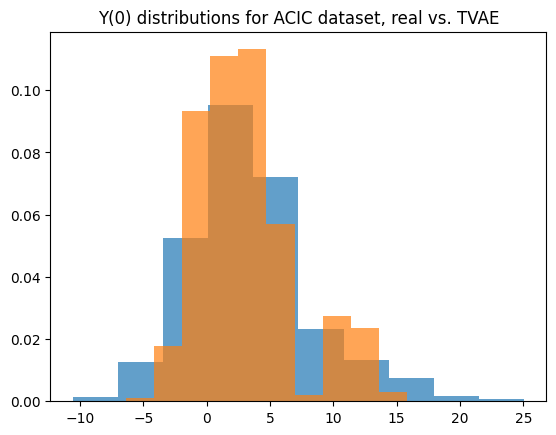

In [178]:
plt.hist(acic_y0['y'], density=True, alpha = 0.7)
plt.hist(acic_y0_syn['y'], density=True, alpha = 0.7)
plt.title('Y(0) distributions for ACIC dataset, real vs. TVAE')
plt.savefig('plots/y0_acic_TVAE.png')

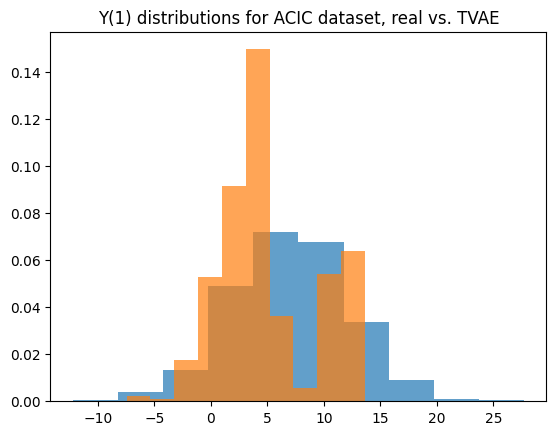

In [179]:
plt.hist(acic_y1['y'], density=True, alpha = 0.7)
plt.hist(acic_y1_syn['y'], density=True, alpha = 0.7)
plt.title('Y(1) distributions for ACIC dataset, real vs. TVAE')
plt.savefig('plots/y1_acic_TVAE.png')

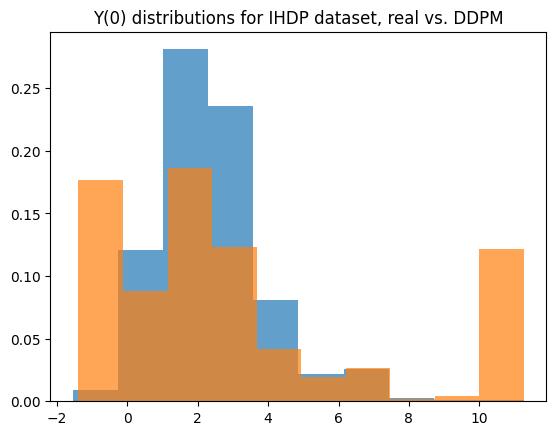

In [180]:
plt.hist(ihdp_y0['y_factual'], density=True, alpha = 0.7)
plt.hist(ihdp_y0_syn['y_factual'], density=True, alpha = 0.7)
plt.title('Y(0) distributions for IHDP dataset, real vs. DDPM')
plt.savefig('plots/y0_ihdp_DDPM.png')

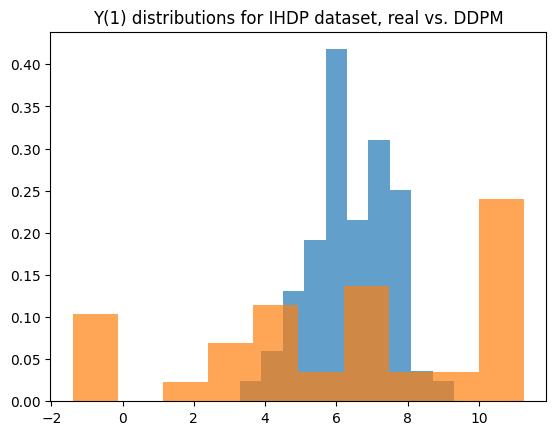

In [181]:
plt.hist(ihdp_y1['y_factual'], density=True, alpha = 0.7)
plt.hist(ihdp_y1_syn['y_factual'], density=True, alpha = 0.7)
plt.title('Y(1) distributions for IHDP dataset, real vs. DDPM')
plt.savefig('plots/y1_ihdp_DDPM.png')

## Simulated experiment

In [ ]:
#checking how the performance discrepancy between real/synthetic trained learners trends as we change the properties of the real dataset.
# Order of X is n_w, n_c, n_o, n_t

In [ ]:
def run_simulation_exp(generators, n_train, n_test, d, n_w=0, n_c=0, n_o=0, n_t=0):


In [10]:
X, y, w, p, cate = simulate_treatment_setup(n=2000, d = 10,)

In [11]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.678495,-0.305499,-0.597381,0.110418,1.197179
1,-0.234137,1.579213,0.767435,-0.469474,0.542560,-0.771042,1.000820,-0.781672,-0.847627,0.818595
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,0.921936,0.851410,-1.315797,-0.465951,0.822989
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0.041542,-1.073693,0.458318,-0.714807,1.794525
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383,1.544841,0.604097,1.361007,0.064791,0.765437
...,...,...,...,...,...,...,...,...,...,...
1995,-0.541773,1.674271,-0.900921,-1.012686,-1.759959,0.659068,-0.742746,-1.033029,0.713735,0.327970
1996,-0.445795,-0.503722,0.525937,0.243891,-1.192973,0.962592,0.512600,-0.753112,0.076102,0.125133
1997,-0.392726,-0.371462,-1.775982,-0.980947,-0.770814,-0.919159,-1.104625,-0.680722,2.036582,-0.412744
1998,1.433625,0.191451,0.662169,-1.498635,1.194214,1.232867,-0.468661,0.888839,0.902492,0.952591


In [30]:
y = pd.DataFrame(y, columns = ['y'])

In [24]:
w = pd.DataFrame(w, columns=['w'])

In [25]:
pd.DataFrame(p)

,0
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5
...,...
1995,0.5
1996,0.5
1997,0.5
1998,0.5


In [26]:
pd.DataFrame(cate)

,0
0,3.059790
1,3.652467
2,7.126189
3,4.259855
4,4.529921
...,...
1995,8.031347
1996,2.211748
1997,5.002741
1998,6.202458


In [41]:
x_and_w_and_y = pd.concat([pd.DataFrame(X), w,y], axis=1)

In [42]:
x_and_w_and_y[[0,1,2,3,4,5,6,7,8,9]] = x_and_w_and_y[[0,1,2,3,4,5,6,7,8,9]]**2

In [43]:
x_and_w_and_y[x_and_w_and_y.w==1].corr()

,0,1,2,3,4,5,6,7,8,9,w,y
0,1.000000,0.029762,-0.034295,0.008411,0.009447,0.023815,0.044701,-0.019942,-0.014759,-0.028222,NaN,0.478872
1,0.029762,1.000000,-0.006053,0.007667,0.000200,0.005411,-0.002178,0.019457,-0.048740,0.007656,NaN,0.463199
2,-0.034295,-0.006053,1.000000,-0.006188,-0.036725,-0.027265,0.026514,-0.036163,0.006675,0.025249,NaN,0.380915
3,0.008411,0.007667,-0.006188,1.000000,-0.015252,-0.029789,-0.002304,-0.013739,0.042818,0.003453,NaN,0.400983
4,0.009447,0.000200,-0.036725,-0.015252,1.000000,-0.036782,-0.007474,-0.007316,-0.024925,-0.019750,NaN,0.385960
5,0.023815,0.005411,-0.027265,-0.029789,-0.036782,1.000000,0.033073,-0.028628,-0.002624,0.042090,NaN,-0.037976
6,0.044701,-0.002178,0.026514,-0.002304,-0.007474,0.033073,1.000000,-0.010020,-0.006126,-0.022497,NaN,0.019973
7,-0.019942,0.019457,-0.036163,-0.013739,-0.007316,-0.028628,-0.010020,1.000000,0.002611,-0.005197,NaN,-0.036355
8,-0.014759,-0.048740,0.006675,0.042818,-0.024925,-0.002624,-0.006126,0.002611,1.000000,-0.004157,NaN,-0.027327
9,-0.028222,0.007656,0.025249,0.003453,-0.019750,0.042090,-0.022497,-0.005197,-0.004157,1.000000,NaN,0.009131


,0,1,2,3,4
0,0.246725,0.019117,0.419500,2.319620,0.054828
1,0.054820,2.493913,0.588956,0.220406,0.294371
2,0.214756,0.216904,0.058546,3.660641,2.975342
3,0.316167,1.025827,0.098751,0.824508,1.994602
4,2.148126,0.050975,0.004560,2.029907,0.296353
...,...,...,...,...,...
1995,0.293518,2.803183,0.811659,1.025532,3.097455
1996,0.198733,0.253736,0.276610,0.059483,1.423185
1997,0.154234,0.137984,3.154113,0.962256,0.594154
1998,2.055281,0.036653,0.438467,2.245908,1.426148


## Jobs overlap investigation

In [15]:
ddpm_jobs = pd.read_csv('syn_data/ddpm_jobs_0.csv')
arf_jobs = pd.read_csv('syn_data/arf_jobs_0.csv')
ctgan_jobs = pd.read_csv('syn_data/ctgan_jobs_0.csv')

In [74]:
alpha_prec = AlphaPrecision()
inv_kl = InverseKLDivergence()

In [75]:
alpha_prec.evaluate(GenericDataLoader(jobs), GenericDataLoader(ddpm_jobs))

{'delta_precision_alpha_OC': 0.8525742668831789,
 'delta_coverage_beta_OC': 0.46952908587257625,
 'authenticity_OC': 0.5290858725761773,
 'delta_precision_alpha_naive': 0.9776260069411278,
 'delta_coverage_beta_naive': 0.4386888273314866,
 'authenticity_naive': 0.5249307479224377}

In [76]:
alpha_prec.evaluate(GenericDataLoader(jobs), GenericDataLoader(arf_jobs))

{'delta_precision_alpha_OC': 0.7975992613111726,
 'delta_coverage_beta_OC': 0.37192982456140355,
 'authenticity_OC': 0.5512465373961218,
 'delta_precision_alpha_naive': 0.9460247715477441,
 'delta_coverage_beta_naive': 0.3907663896583564,
 'authenticity_naive': 0.5193905817174516}

In [77]:
alpha_prec.evaluate(GenericDataLoader(jobs), GenericDataLoader(ctgan_jobs))

{'delta_precision_alpha_OC': 0.7825484764542936,
 'delta_coverage_beta_OC': 0.35226223453370265,
 'authenticity_OC': 0.5955678670360111,
 'delta_precision_alpha_naive': 0.9044894450281784,
 'delta_coverage_beta_naive': 0.28661126500461687,
 'authenticity_naive': 0.5332409972299169}

In [78]:
inv_kl.evaluate(GenericDataLoader(jobs), GenericDataLoader(ddpm_jobs))

{'marginal': 0.9645127672177645}

In [79]:
inv_kl.evaluate(GenericDataLoader(jobs), GenericDataLoader(arf_jobs))

{'marginal': 0.9793652087514038}

In [80]:
inv_kl.evaluate(GenericDataLoader(jobs), GenericDataLoader(ctgan_jobs))

{'marginal': 0.8643986935248725}

In [52]:
true_prop = jobs.groupby(['hispanic', 'married', 'no_degree']).mean()['training'].values

In [66]:
jobs.groupby(['hispanic', 'married', 'no_degree']).mean()

training        age  education     black  \
hispanic married no_degree                                             
0.0      0.0     0.0        0.515873  25.587302  12.357143  0.817460   
                 1.0        0.383133  23.604819   9.725301  0.915663   
         1.0     0.0        0.458333  28.416667  12.416667  0.833333   
                 1.0        0.419753  28.506173   9.888889  0.925926   
1.0      0.0     0.0        0.333333  25.666667  12.000000  0.000000   
                 1.0        0.362069  21.775862   9.120690  0.000000   
         1.0     0.0        0.666667  26.000000  12.000000  0.000000   
                 1.0        0.333333  22.000000   9.333333  0.000000   

                                   re75         re78  
hispanic married no_degree                            
0.0      0.0     0.0        3203.203282  6275.410945  
                 1.0        2310.429302  4853.388856  
         1.0     0.0        5774.359329  6868.729692  
                 1.0        5672.412035  5902.632714  
1.0      0.0     0.0        8176.727883  7815.005367  
                 1.0        2620.543896  6617.259948  
         1.0     0.0        4755.937333  7771.219333  
                 1.0        2352.203244  4046.822000

In [53]:
ddpm_prop = ddpm_jobs.groupby(['hispanic', 'married', 'no_degree']).mean()['training'].values

In [54]:
ctgan_prop = ctgan_jobs.groupby(['hispanic', 'married', 'no_degree']).mean()['training'].values

In [55]:
arf_prop = arf_jobs.groupby(['hispanic', 'married', 'no_degree']).mean()['training'].values

In [56]:
mean_squared_error(true_prop, ddpm_prop)

0.04365453009008789

In [57]:
mean_squared_error(true_prop, arf_prop)

0.0058548580724429

In [58]:
mean_squared_error(true_prop, ctgan_prop)

0.02969861994641387

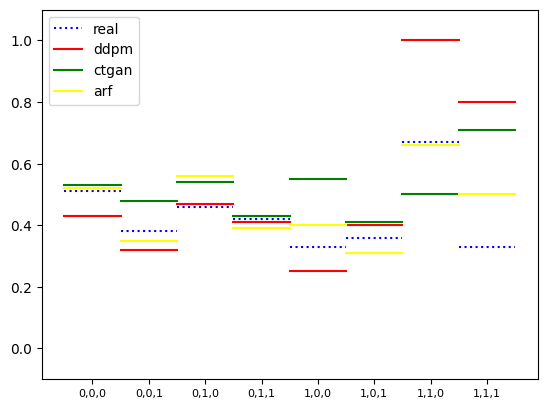

<Figure size 640x480 with 0 Axes>

In [73]:

x_values1 = [0, 0.125]
y_values1 = [0.51, 0.51]
y_values1_ddpm = [0.43, 0.43]
y_values1_ctgan = [0.53, 0.53]
y_values1_arf = [0.52, 0.52]

x_values2 = [0.125, 0.25]
y_values2 = [0.38, 0.38]
y_values2_ddpm = [0.32, 0.32]
y_values2_ctgan = [0.48, 0.48]
y_values2_arf = [0.35, 0.35]

x_values3 = [0.25, 0.375]
y_values3 = [0.46, 0.46]
y_values3_ddpm = [0.47, 0.47]
y_values3_ctgan = [0.54, 0.54]
y_values3_arf = [0.56, 0.56]

x_values4 = [0.375, 0.5]
y_values4 = [0.42, 0.42]
y_values4_ddpm = [0.41, 0.41]
y_values4_ctgan = [0.43, 0.43]
y_values4_arf = [0.39, 0.39]

x_values5 = [0.5, 0.625]
y_values5 = [0.33, 0.33]
y_values5_ddpm = [0.25, 0.25]
y_values5_ctgan = [0.55, 0.55]
y_values5_arf = [0.40, 0.40]

x_values6 = [0.625, 0.75]
y_values6 = [0.36, 0.36]
y_values6_ddpm = [0.40, 0.40]
y_values6_ctgan = [0.41, 0.41]
y_values6_arf = [0.31, 0.31]

x_values7 = [0.75, 0.875]
y_values7 = [0.67, 0.67]
y_values7_ddpm = [1, 1]
y_values7_ctgan = [0.5, 0.5]
y_values7_arf = [0.66, 0.66]

x_values8 = [0.875, 1]
y_values8 = [0.33, 0.33]
y_values8_ddpm = [0.8, 0.8]
y_values8_ctgan = [0.71, 0.71]
y_values8_arf = [0.5, 0.5]

# Plot the first horizontal line
plt.plot(x_values1, y_values1, color='blue',linestyle=':')
plt.plot(x_values2, y_values2, color='blue',linestyle=':')
plt.plot(x_values3, y_values3, color='blue',linestyle=':')
plt.plot(x_values4, y_values4, color='blue',linestyle=':')
plt.plot(x_values5, y_values5, color='blue',linestyle=':')
plt.plot(x_values6, y_values6, color='blue',linestyle=':')
plt.plot(x_values7, y_values7, color='blue',linestyle=':')
plt.plot(x_values8, y_values8, color='blue',linestyle=':', label = 'real')

plt.plot(x_values1, y_values1_ddpm, color='red')
plt.plot(x_values2, y_values2_ddpm, color='red')
plt.plot(x_values3, y_values3_ddpm, color='red')
plt.plot(x_values4, y_values4_ddpm, color='red')
plt.plot(x_values5, y_values5_ddpm, color='red')
plt.plot(x_values6, y_values6_ddpm, color='red')
plt.plot(x_values7, y_values7_ddpm, color='red')
plt.plot(x_values8, y_values8_ddpm, color='red', label = 'ddpm')

plt.plot(x_values1, y_values1_ctgan, color='green')
plt.plot(x_values2, y_values2_ctgan, color='green')
plt.plot(x_values3, y_values3_ctgan, color='green')
plt.plot(x_values4, y_values4_ctgan, color='green')
plt.plot(x_values5, y_values5_ctgan, color='green')
plt.plot(x_values6, y_values6_ctgan, color='green')
plt.plot(x_values7, y_values7_ctgan, color='green')
plt.plot(x_values8, y_values8_ctgan, color='green', label = 'ctgan')

plt.plot(x_values1, y_values1_arf, color='yellow')
plt.plot(x_values2, y_values2_arf, color='yellow')
plt.plot(x_values3, y_values3_arf, color='yellow')
plt.plot(x_values4, y_values4_arf, color='yellow')
plt.plot(x_values5, y_values5_arf, color='yellow')
plt.plot(x_values6, y_values6_arf, color='yellow')
plt.plot(x_values7, y_values7_arf, color='yellow')
plt.plot(x_values8, y_values8_arf, color='yellow', label = 'arf')

# Plot the dotted black faint line at y=0.5
#plt.axhline(y=0.5, color='black', linestyle=':', alpha=0.6, label='Horizontal Line at y=0.5')

# Set y-axis limits
plt.ylim(-0.1, 1.1)

# Hide x-axis ticks and labels
plt.xticks([0.0625, 0.0625+0.125, 0.0625+0.25, 0.0625+0.375, 0.0625+0.5, 0.0625+0.625, 0.0625+0.75,0.0625+0.875], ['0,0,0', '0,0,1', '0,1,0', '0,1,1', '1,0,0', '1,0,1', '1,1,0', '1,1,1'], fontsize = 8)


# Add labels below the lines
#plt.text(0.25, 0.35, 'group1', horizontalalignment='center')
#plt.text(0.75, 0.55, 'group2', horizontalalignment='center')

plt.legend(loc = 'upper left')
# Display the plot
plt.show()
plt.savefig('plots/propensity_scores.png')

In [26]:
inv_kl = InverseKLDivergence()
alpha = AlphaPrecision()

In [28]:
ihdp.loc[:, 'treatment']= ihdp['treatment'].replace(True, 1).replace(False, 0)
ihdp_wrong = ihdp.copy()
ihdp_wrong['treatment'] = 0

In [32]:
syn_data = {}

for i in listdir('syn_data'):
    if 'acic' in i:
        syn_data[i] = pd.read_csv('syn_data/'+i)

acic_encoded, syn_data_encoded = encode_acic_datasets(acic, syn_data)

acic_wrong = acic_encoded.copy()
acic_wrong['z'] = 0

In [29]:
inv_kl.evaluate(GenericDataLoader(ihdp), GenericDataLoader(ihdp_wrong))

{'marginal': 0.9700411356240279}

In [31]:
alpha.evaluate(GenericDataLoader(ihdp), GenericDataLoader(ihdp_wrong))

{'delta_precision_alpha_OC': 0.9847204911600425,
 'delta_coverage_beta_OC': 0.950871685977627,
 'authenticity_OC': 0.09772423025435073,
 'delta_precision_alpha_naive': 0.9054886211512718,
 'delta_coverage_beta_naive': 0.9130745203034359,
 'authenticity_naive': 0.050870147255689425}

In [34]:
inv_kl.evaluate(GenericDataLoader(acic_encoded), GenericDataLoader(acic_wrong))

{'marginal': 0.9904497292567366}

In [35]:
alpha.evaluate(GenericDataLoader(acic_encoded), GenericDataLoader(acic_wrong))

{'delta_precision_alpha_OC': 0.9979400345641424,
 'delta_coverage_beta_OC': 0.9704567541302236,
 'authenticity_OC': 0.07559350270720533,
 'delta_precision_alpha_naive': 0.9358878245175621,
 'delta_coverage_beta_naive': 0.8509371095376926,
 'authenticity_naive': 0.1376509787588505}

In [38]:
jobs_wrong = jobs.copy()
jobs_wrong['training'] = 0

In [40]:
inv_kl.evaluate(GenericDataLoader(jobs),GenericDataLoader(jobs_wrong))

{'marginal': 0.899232802939961}

In [41]:
alpha.evaluate(GenericDataLoader(jobs),GenericDataLoader(jobs_wrong))

{'delta_precision_alpha_OC': 0.9852803515139937,
 'delta_coverage_beta_OC': 0.8950870824975324,
 'authenticity_OC': 0.1814404432132964,
 'delta_precision_alpha_naive': 0.8650046168051708,
 'delta_coverage_beta_naive': 0.5986149584487535,
 'authenticity_naive': 0.4113573407202216}

In [43]:
test = jobs[['training', 'black']]
test_wrong = test.copy()
test_wrong['training'] = 0

In [44]:
inv_kl.evaluate(GenericDataLoader(test),GenericDataLoader(test_wrong))

{'marginal': 0.5465476132298248}

In [46]:
alpha.evaluate(GenericDataLoader(test),GenericDataLoader(test_wrong))

{'delta_precision_alpha_OC': 0.6607062119909575,
 'delta_coverage_beta_OC': 0.5125736300824656,
 'authenticity_OC': 0.4113573407202216,
 'delta_precision_alpha_naive': 0.0,
 'delta_coverage_beta_naive': 0.4679912121501576,
 'authenticity_naive': 0.4113573407202216}